In [2]:
from utils import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

# Define the model
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(19, 1000),   
    nn.LeakyReLU(),
    nn.Dropout(0.8),
    nn.Linear(1000, 500),
    nn.LeakyReLU(),
    nn.Dropout(0.3),
    nn.Linear(500, 200),   
    nn.LeakyReLU(),
    nn.Dropout(0.3),
    nn.Linear(200, 30),   
    nn.LeakyReLU(),
    nn.Dropout(0.3),
    nn.Linear(30, 1),   
)

# Parameters
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

combined = numerize_csv('train.csv', target_encode=True)

#Data
Y = combined['Discontinued']
X = combined.drop('Discontinued', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0, train_size = .75)

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)  
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32) 

y_train_tensor = y_train_tensor.view(-1, 1) 
y_test_tensor = y_test_tensor.view(-1, 1)

test_scores = []
train_scores = []
test_accs = []

# Training
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()  
    optimizer.zero_grad()  

    outputs = model(X_train_tensor) 
    loss = loss_fn(outputs, y_train_tensor)
    train_scores.append(roc_auc_score(y_train_tensor.detach().numpy(), outputs.detach().numpy()))
    loss.backward()  
    optimizer.step() 
    model.eval() 
    with torch.no_grad():
        outputs = model(X_test_tensor)
        # test_loss = loss_fn(outputs, y_test_tensor)
        test_scores.append(roc_auc_score(y_test_tensor, outputs))
        test_accs.append(accuracy_score(y_test_tensor, torch.round(outputs)))

0.8016467065868264

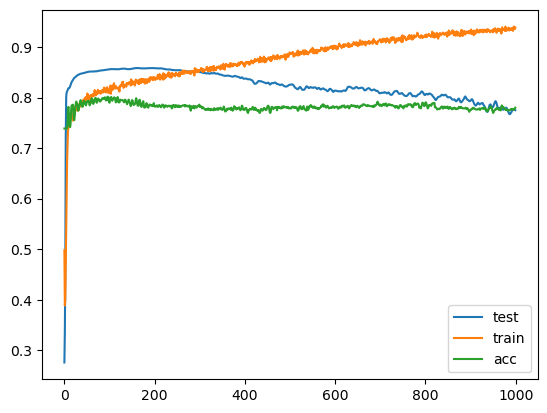

In [5]:
plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.plot(test_accs, label='acc')
plt.legend()
max(test_accs)

In [4]:
combined = numerize_csv('test.csv', train=False, expand_classes=False)
# combined.drop('Discontinued')
X = torch.tensor(combined.values, dtype=torch.float32)
write_submission(model(X).detach().numpy()[:, 0])